In [4]:
import os
import pandas as pd
import pandasai as pai
from pandasai_litellm.litellm import LiteLLM
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

llm = LiteLLM(model="gpt‑3.5‑turbo", api_key=os.getenv("OPENAI_API_KEY"))
pai.config.set({"llm": llm})

df = pd.read_csv("agriculture.csv")
print(df.head())
print(df.info())


# Create in-memory SQLite DB
conn = sqlite3.connect(":memory:")

# Store df into SQL
df.to_sql("funding", conn, index=False, if_exists="replace")

   Dist Code  Year  State Code    State Name Dist Name  RICE AREA (1000 ha)  \
0          1  1966          14  Chhattisgarh      Durg                548.0   
1          1  1967          14  Chhattisgarh      Durg                547.0   
2          1  1968          14  Chhattisgarh      Durg                556.3   
3          1  1969          14  Chhattisgarh      Durg                563.4   
4          1  1970          14  Chhattisgarh      Durg                571.6   

   RICE PRODUCTION (1000 tons)  RICE YIELD (Kg per ha)  WHEAT AREA (1000 ha)  \
0                        185.0                  337.59                  44.0   
1                        409.0                  747.71                  50.0   
2                        468.0                  841.27                  53.7   
3                        400.8                  711.40                  49.4   
4                        473.6                  828.55                  44.2   

   WHEAT PRODUCTION (1000 tons)  ...  SUGARC

16146

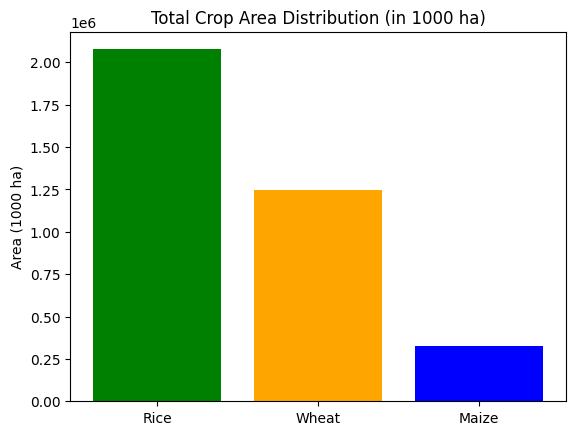

In [5]:
# Crop Area Distribution (Rice, Wheat, Maize)

area_totals = {
    "Rice": df["RICE AREA (1000 ha)"].sum(),
    "Wheat": df["WHEAT AREA (1000 ha)"].sum(),
    "Maize": df["MAIZE AREA (1000 ha)"].sum()
}

# Bar chart
plt.bar(area_totals.keys(), area_totals.values(), color=["green", "orange", "blue"])
plt.title("Total Crop Area Distribution (in 1000 ha)")
plt.ylabel("Area (1000 ha)")
plt.show()


c:\Users\Kinjal\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Kinjal\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


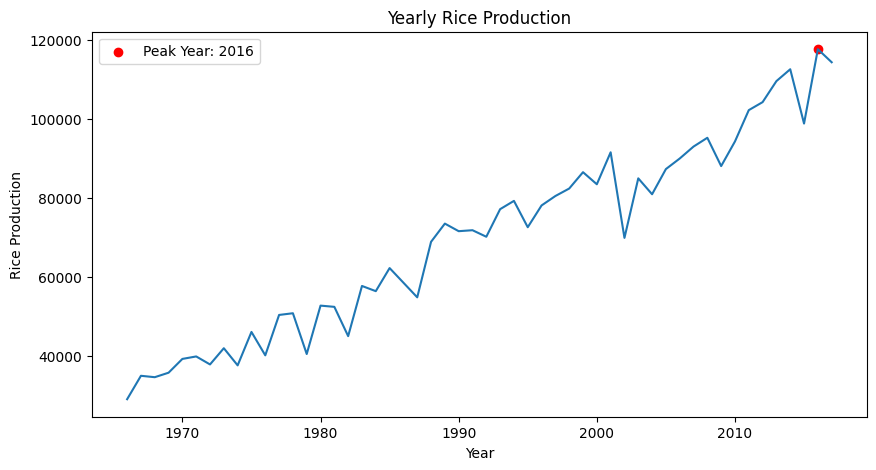

In [6]:
# Yearly Production (Rice)

# Group by Year for total rice production
yearly_rice = df.groupby("Year")["RICE PRODUCTION (1000 tons)"].sum()

# Identify peak year
peak_year = yearly_rice.idxmax()
peak_value = yearly_rice.max()

# Line chart
plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_rice)
plt.scatter(peak_year, peak_value, color='red', label=f'Peak Year: {peak_year}')
plt.title("Yearly Rice Production")
plt.xlabel("Year")
plt.ylabel("Rice Production")
plt.legend()
plt.show()


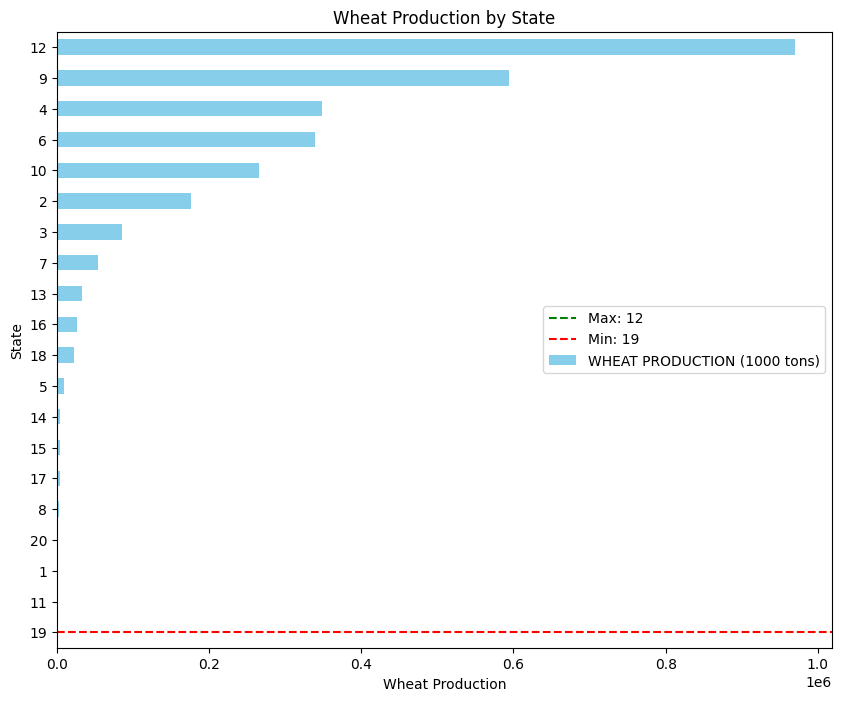

In [7]:
# State Production (Wheat)

# Group by State
wheat_state = df.groupby("State Code")["WHEAT PRODUCTION (1000 tons)"].sum().sort_values()

# Get highest and lowest
max_state = wheat_state.idxmax()
min_state = wheat_state.idxmin()

# Horizontal bar chart
plt.figure(figsize=(10, 8))
wheat_state.plot(kind='barh', color='skyblue')
plt.title("Wheat Production by State")
plt.xlabel("Wheat Production")
plt.ylabel("State")
plt.axhline(wheat_state[max_state], color='green', linestyle='--', label=f'Max: {max_state}')
plt.axhline(wheat_state[min_state], color='red', linestyle='--', label=f'Min: {min_state}')
plt.legend()
plt.show()


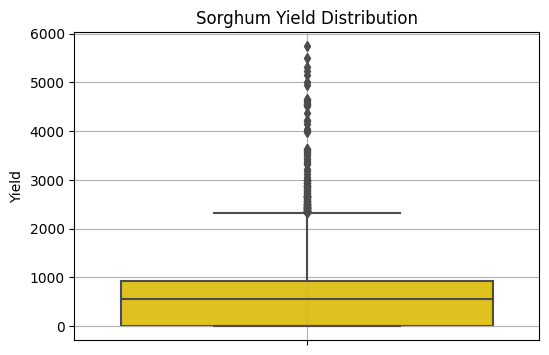

In [8]:
# Crop Yields (Sorghum)

# Box plot for sorghum yield
plt.figure(figsize=(6, 4))
sns.boxplot(y=df["SORGHUM YIELD (Kg per ha)"], color='gold')
plt.title("Sorghum Yield Distribution")
plt.ylabel("Yield")
plt.grid(True)
plt.show()


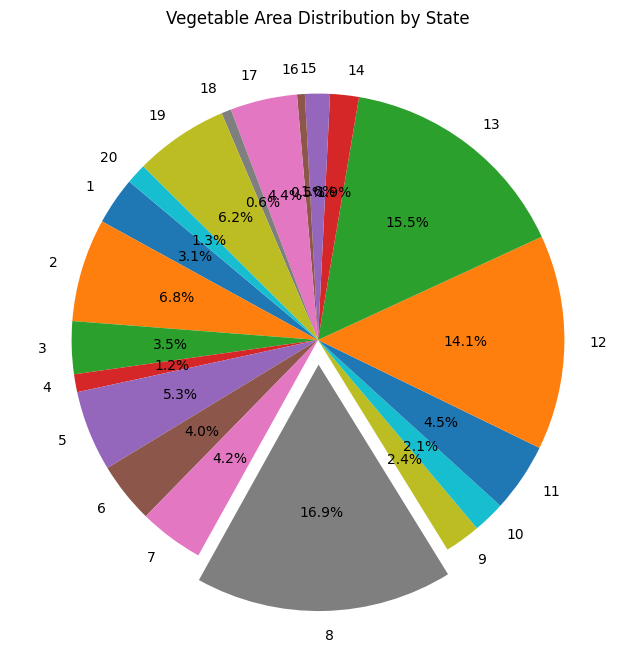

In [9]:
# Vegetable Area (State-wise)

# Group by State Code
vegetable_state = df.groupby("State Code")["VEGETABLES AREA (1000 ha)"].sum()

# Identify max state
max_veg_state = vegetable_state.idxmax()

# Pie chart
plt.figure(figsize=(8, 8))
explode = [0.1 if state == max_veg_state else 0 for state in vegetable_state.index]
plt.pie(vegetable_state, labels=vegetable_state.index, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title("Vegetable Area Distribution by State")
plt.show()


Pearson correlation coefficient: 0.91


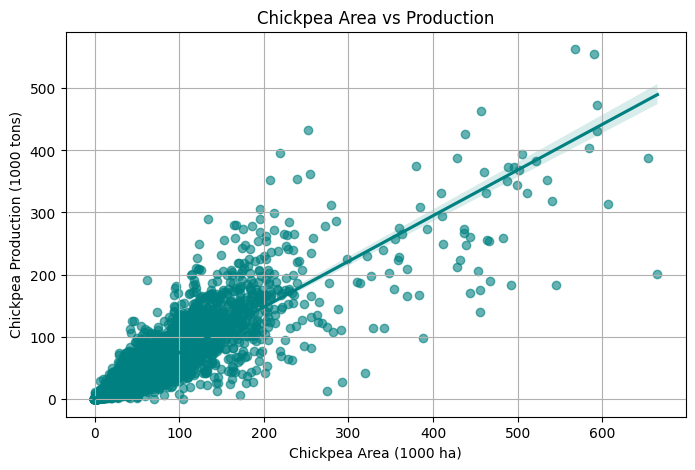

In [12]:
from scipy.stats import pearsonr
# Correlation between Chickpea area and Chickpea production
correlation, _ = pearsonr(df["CHICKPEA AREA (1000 ha)"], df["CHICKPEA PRODUCTION (1000 tons)"])
print(f"Pearson correlation coefficient: {correlation:.2f}")
    
# Scatter plot with trendline
plt.figure(figsize=(8, 5))
sns.regplot(x="CHICKPEA AREA (1000 ha)", y="CHICKPEA PRODUCTION (1000 tons)", data=df, color="teal", scatter_kws={"alpha": 0.6})
plt.title("Chickpea Area vs Production")
plt.xlabel("Chickpea Area (1000 ha)")
plt.ylabel("Chickpea Production (1000 tons)")
plt.grid(True)
plt.show()

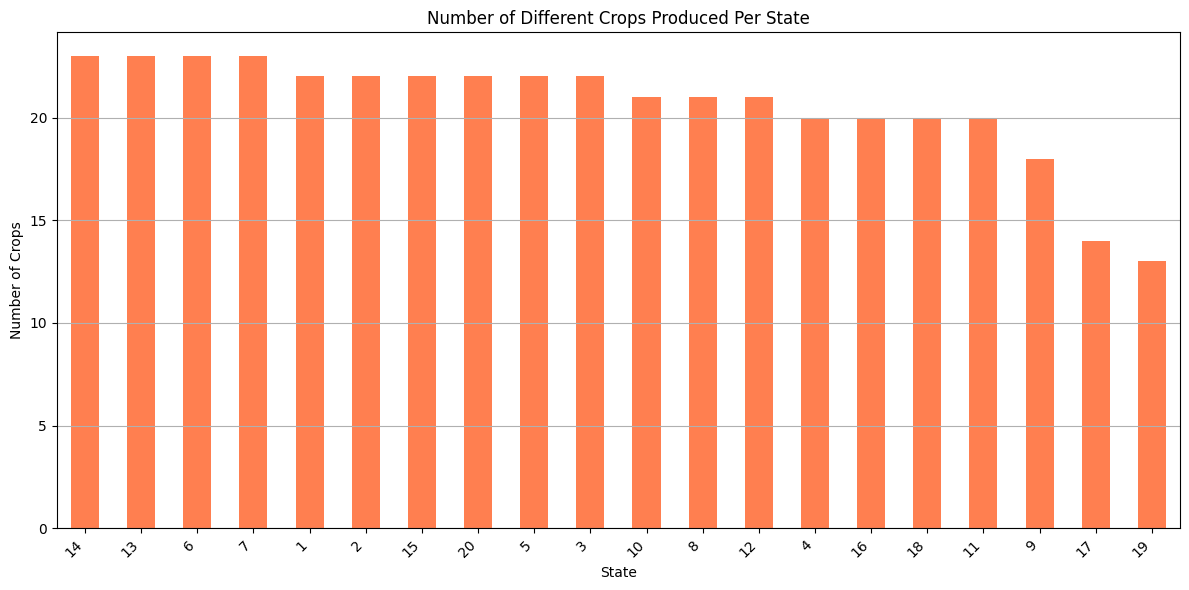

In [14]:
# Number of different crops produced in each state

production_cols = [col for col in df.columns if "PRODUCTION" in col]

# Boolean mask for non-zero production
crop_presence = df[["State Code"] + production_cols].copy()
crop_presence[production_cols] = crop_presence[production_cols] > 0

# Count number of crops produced per state
crop_counts = crop_presence.groupby("State Code")[production_cols].sum()
crop_diversity = crop_counts.gt(0).sum(axis=1).sort_values(ascending=False)

# Bar chart
plt.figure(figsize=(12, 6))
crop_diversity.plot(kind="bar", color="coral")
plt.title("Number of Different Crops Produced Per State")
plt.ylabel("Number of Crops")
plt.xlabel("State")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y")
plt.show()




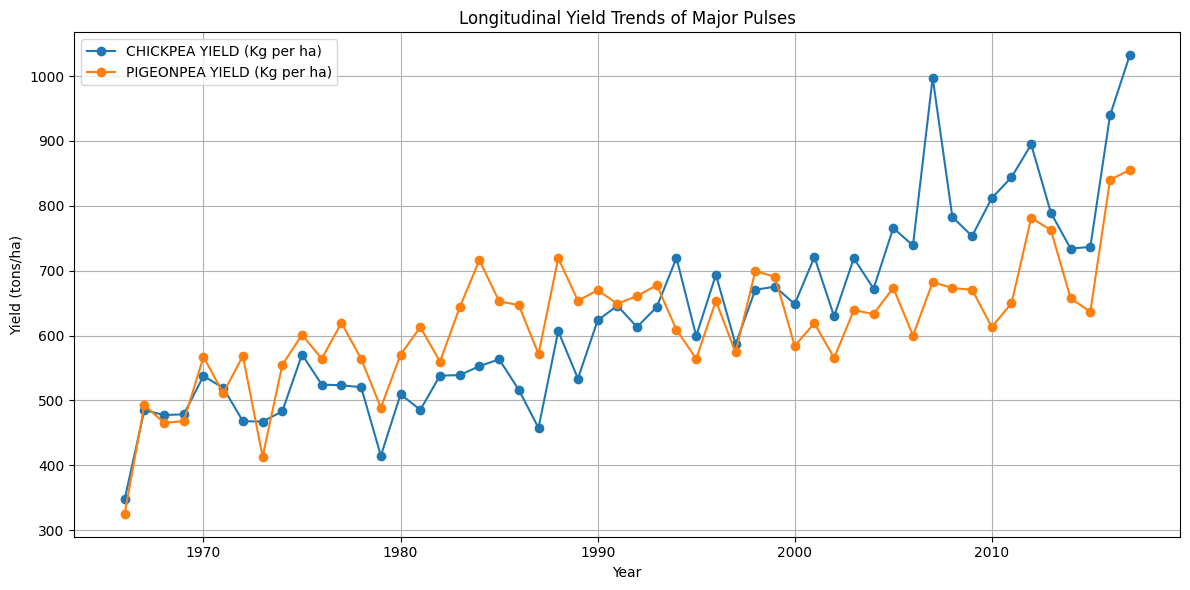

In [19]:
# Track how yields of major pulses have changed over the years

pulse_yield_cols = [col for col in df.columns if "YIELD" in col and any(pulse in col.lower() for pulse in ["chickpea", "pigeonpea"])]

if "Year" in df.columns and pulse_yield_cols:
    pulses_by_year = df.groupby("Year")[pulse_yield_cols].mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    for col in pulse_yield_cols:
        plt.plot(pulses_by_year.index, pulses_by_year[col], marker='o', label=col.replace("_Yield", ""))
    
    plt.title("Longitudinal Yield Trends of Major Pulses")
    plt.xlabel("Year")
    plt.ylabel("Yield (tons/ha)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("❌ 'Year' column or pulse yield columns not found.")

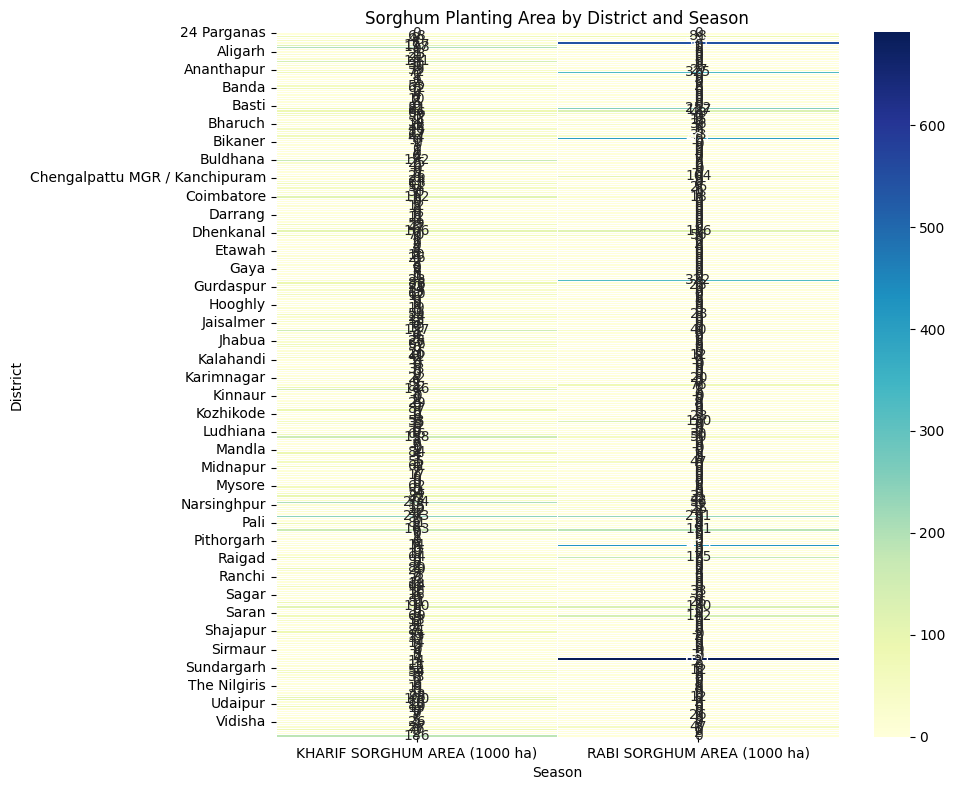

In [22]:
# Show planting patterns for Kharif and Rabi Sorghum by district

sorghum_area = df.groupby("Dist Name")[["KHARIF SORGHUM AREA (1000 ha)", "RABI SORGHUM AREA (1000 ha)"]].mean()
    
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorghum_area, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Sorghum Planting Area by District and Season")
plt.ylabel("District")
plt.xlabel("Season")
plt.tight_layout()
plt.show()